In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta


In [2]:
import numpy as np
import pandas as pd
import datetime as dt



# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from flask import Flask

from sqlalchemy import create_engine, text, inspect, func, distinct 


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()


In [5]:
# Declare a Base using `automap_base()`
Base= automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement= Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session=Session(engine)

In [9]:
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
station_columns= inspector.get_columns('station')
print("Measurement Table Columns:")
for c in measurement_columns:
   print(c['name'], c["type"])

print("\nStation Table Columns:")
for c in station_columns:
   print(c['name'], c["type"])

Measurement Table Columns:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station Table Columns:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [16]:
# Find the most recent date in the data set.
most_recent_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

Most recent date: 2017-08-23 00:00:00
Date one year ago: 2016-08-23 00:00:00


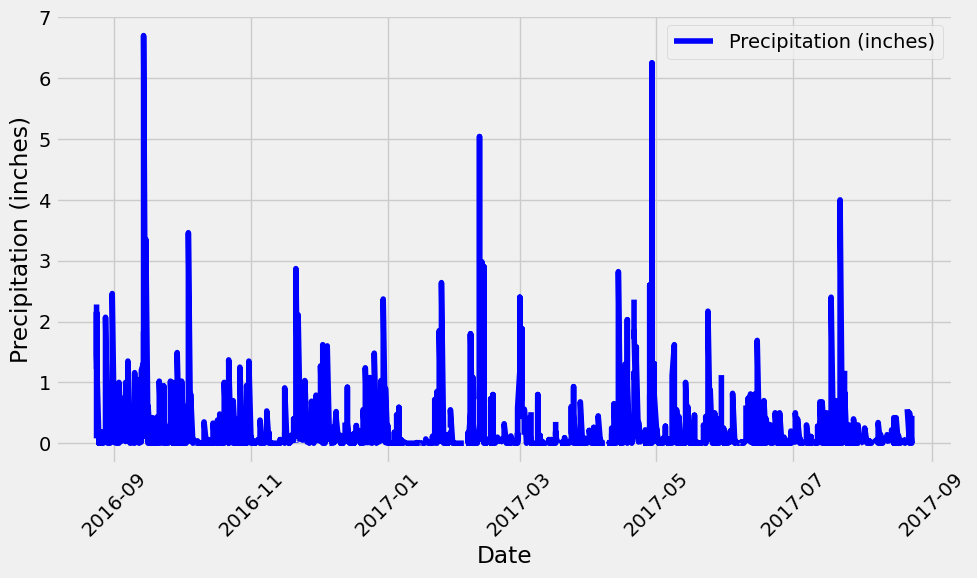

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date[0]
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - relativedelta(years=1)

print(f"Most recent date: {most_recent_date}")
print(f"Date one year ago: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
dates = [datetime.strptime(record[0], '%Y-%m-%d') for record in precipitation_data]
precipitation = [record[1] for record in precipitation_data]

# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,6))
plt.plot(dates, precipitation, label='Precipitation (inches)', color='b')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Measurement.station)).all()
session.query(func.count(distinct(Station.station))).all()

[(9,)]

In [24]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station,
func.count(Measurement.station).label('count')).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'

temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).all()


min_temp, max_temp, avg_temp = temperature_stats[0]
print(f"Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp}")



Station ID: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


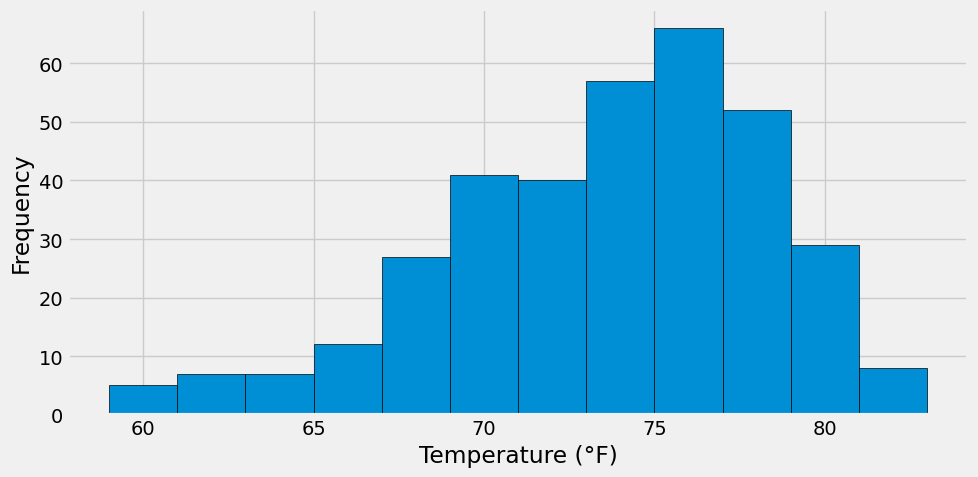

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = 'USC00519281'
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

temperatures = [data.tobs for data in temperature_data]

plt.figure(figsize=(10, 5))
plt.hist(temperatures, bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# Close Session

In [27]:
# Close Session
session.close()
